### Project 1 — End-to-End ML Workflow 

This notebook orchestrates the full classification workflow:

1) **Load & Preprocess & Train/Val/Test Splits** 

2) **Model Showcases**  

3) **Evaluation**  
---

In [1]:
# set working directory to project root
import os
os.chdir("..")  # or full path to project root
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.preprocess import DataHandler
from scripts.perceptron_model import Perceptron
from scripts.adalinesgd_model import AdalineSGD
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scripts.plots import plot_confusion_matrix as pltcm, plot_svm_decision_boundaries_multi_feature as pltdbmult
from scripts.plots import plot_best_svm_decision_boundary as pltdbbest
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

#### Preprocessing:

In [2]:
# read in data
data_handler = DataHandler()
data_handler.load_data_into_class(file_path="data/project_adult.csv")

# split into train and test
X_train, X_test, y_train, y_test = data_handler.split_data(target_column="income", filepath="data/project_adult.csv")

# preprocess the data
X_train_processed = data_handler.preprocess_set(X_train, train_or_test="train")
X_test_processed = data_handler.preprocess_set(X_test, train_or_test="test")

#### Training Perceptron and Adaline:

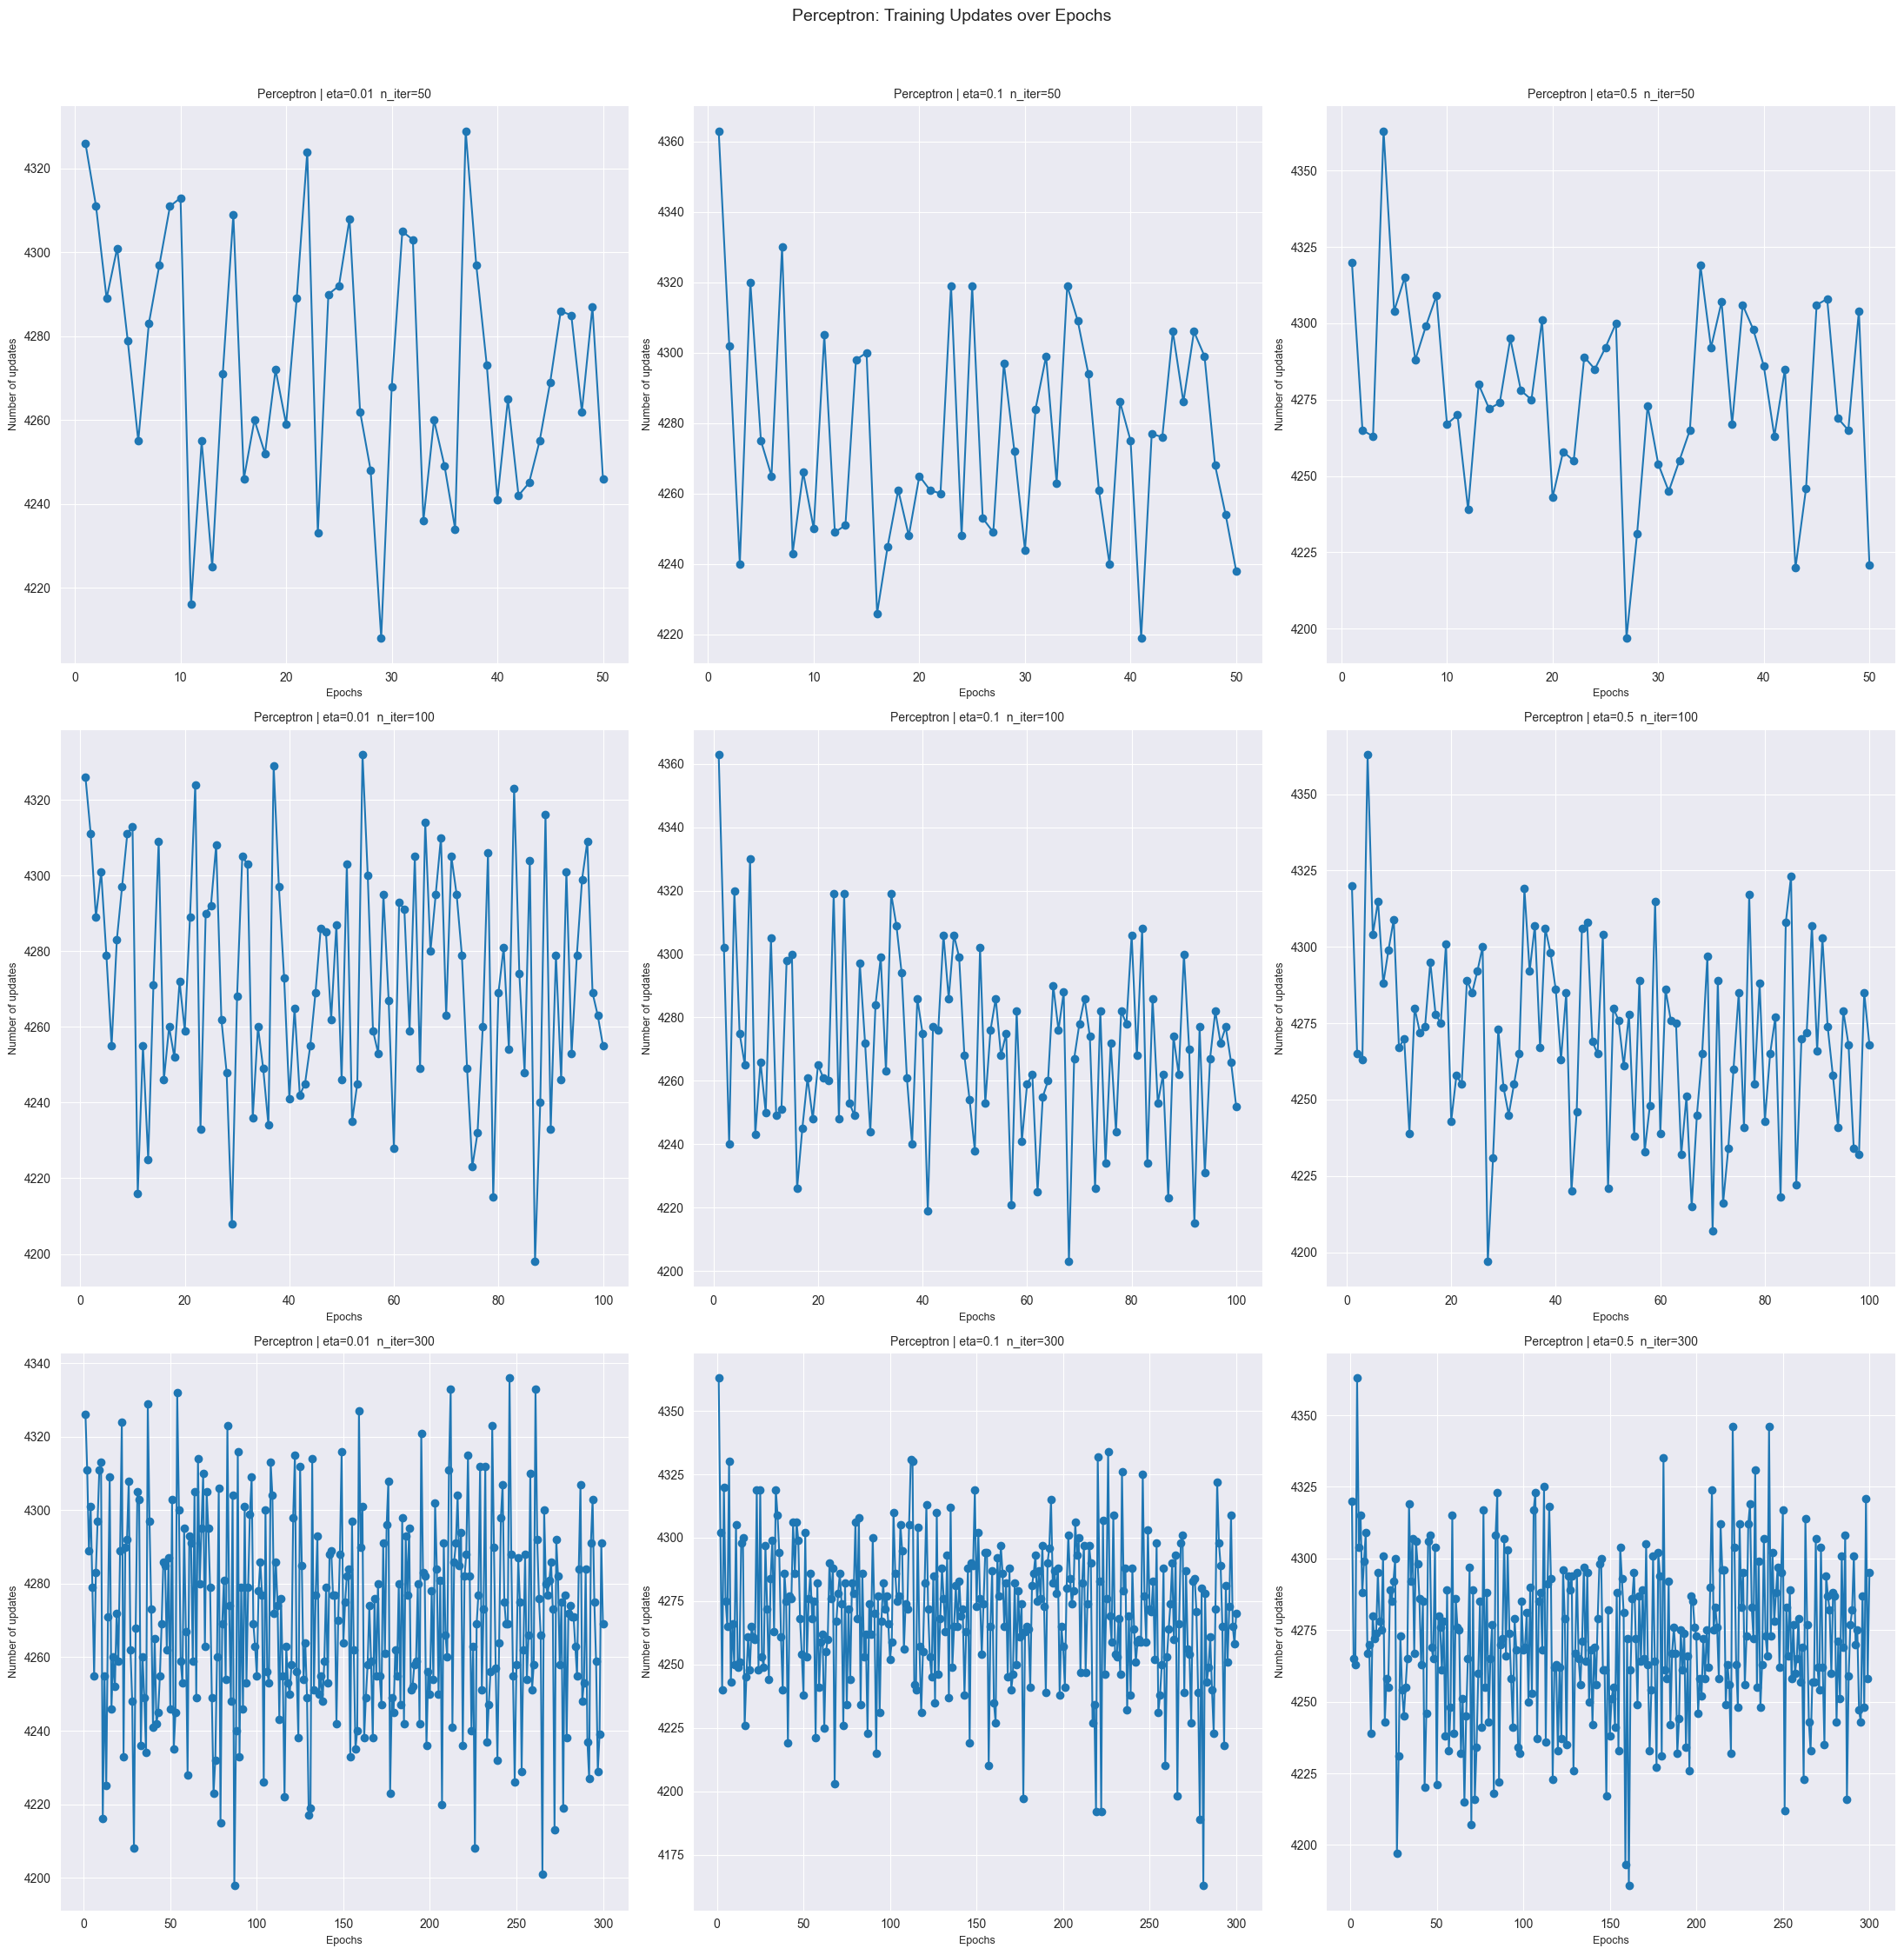

Perceptron best config: {'eta': 0.5, 'n_iter': 50} score: 4221


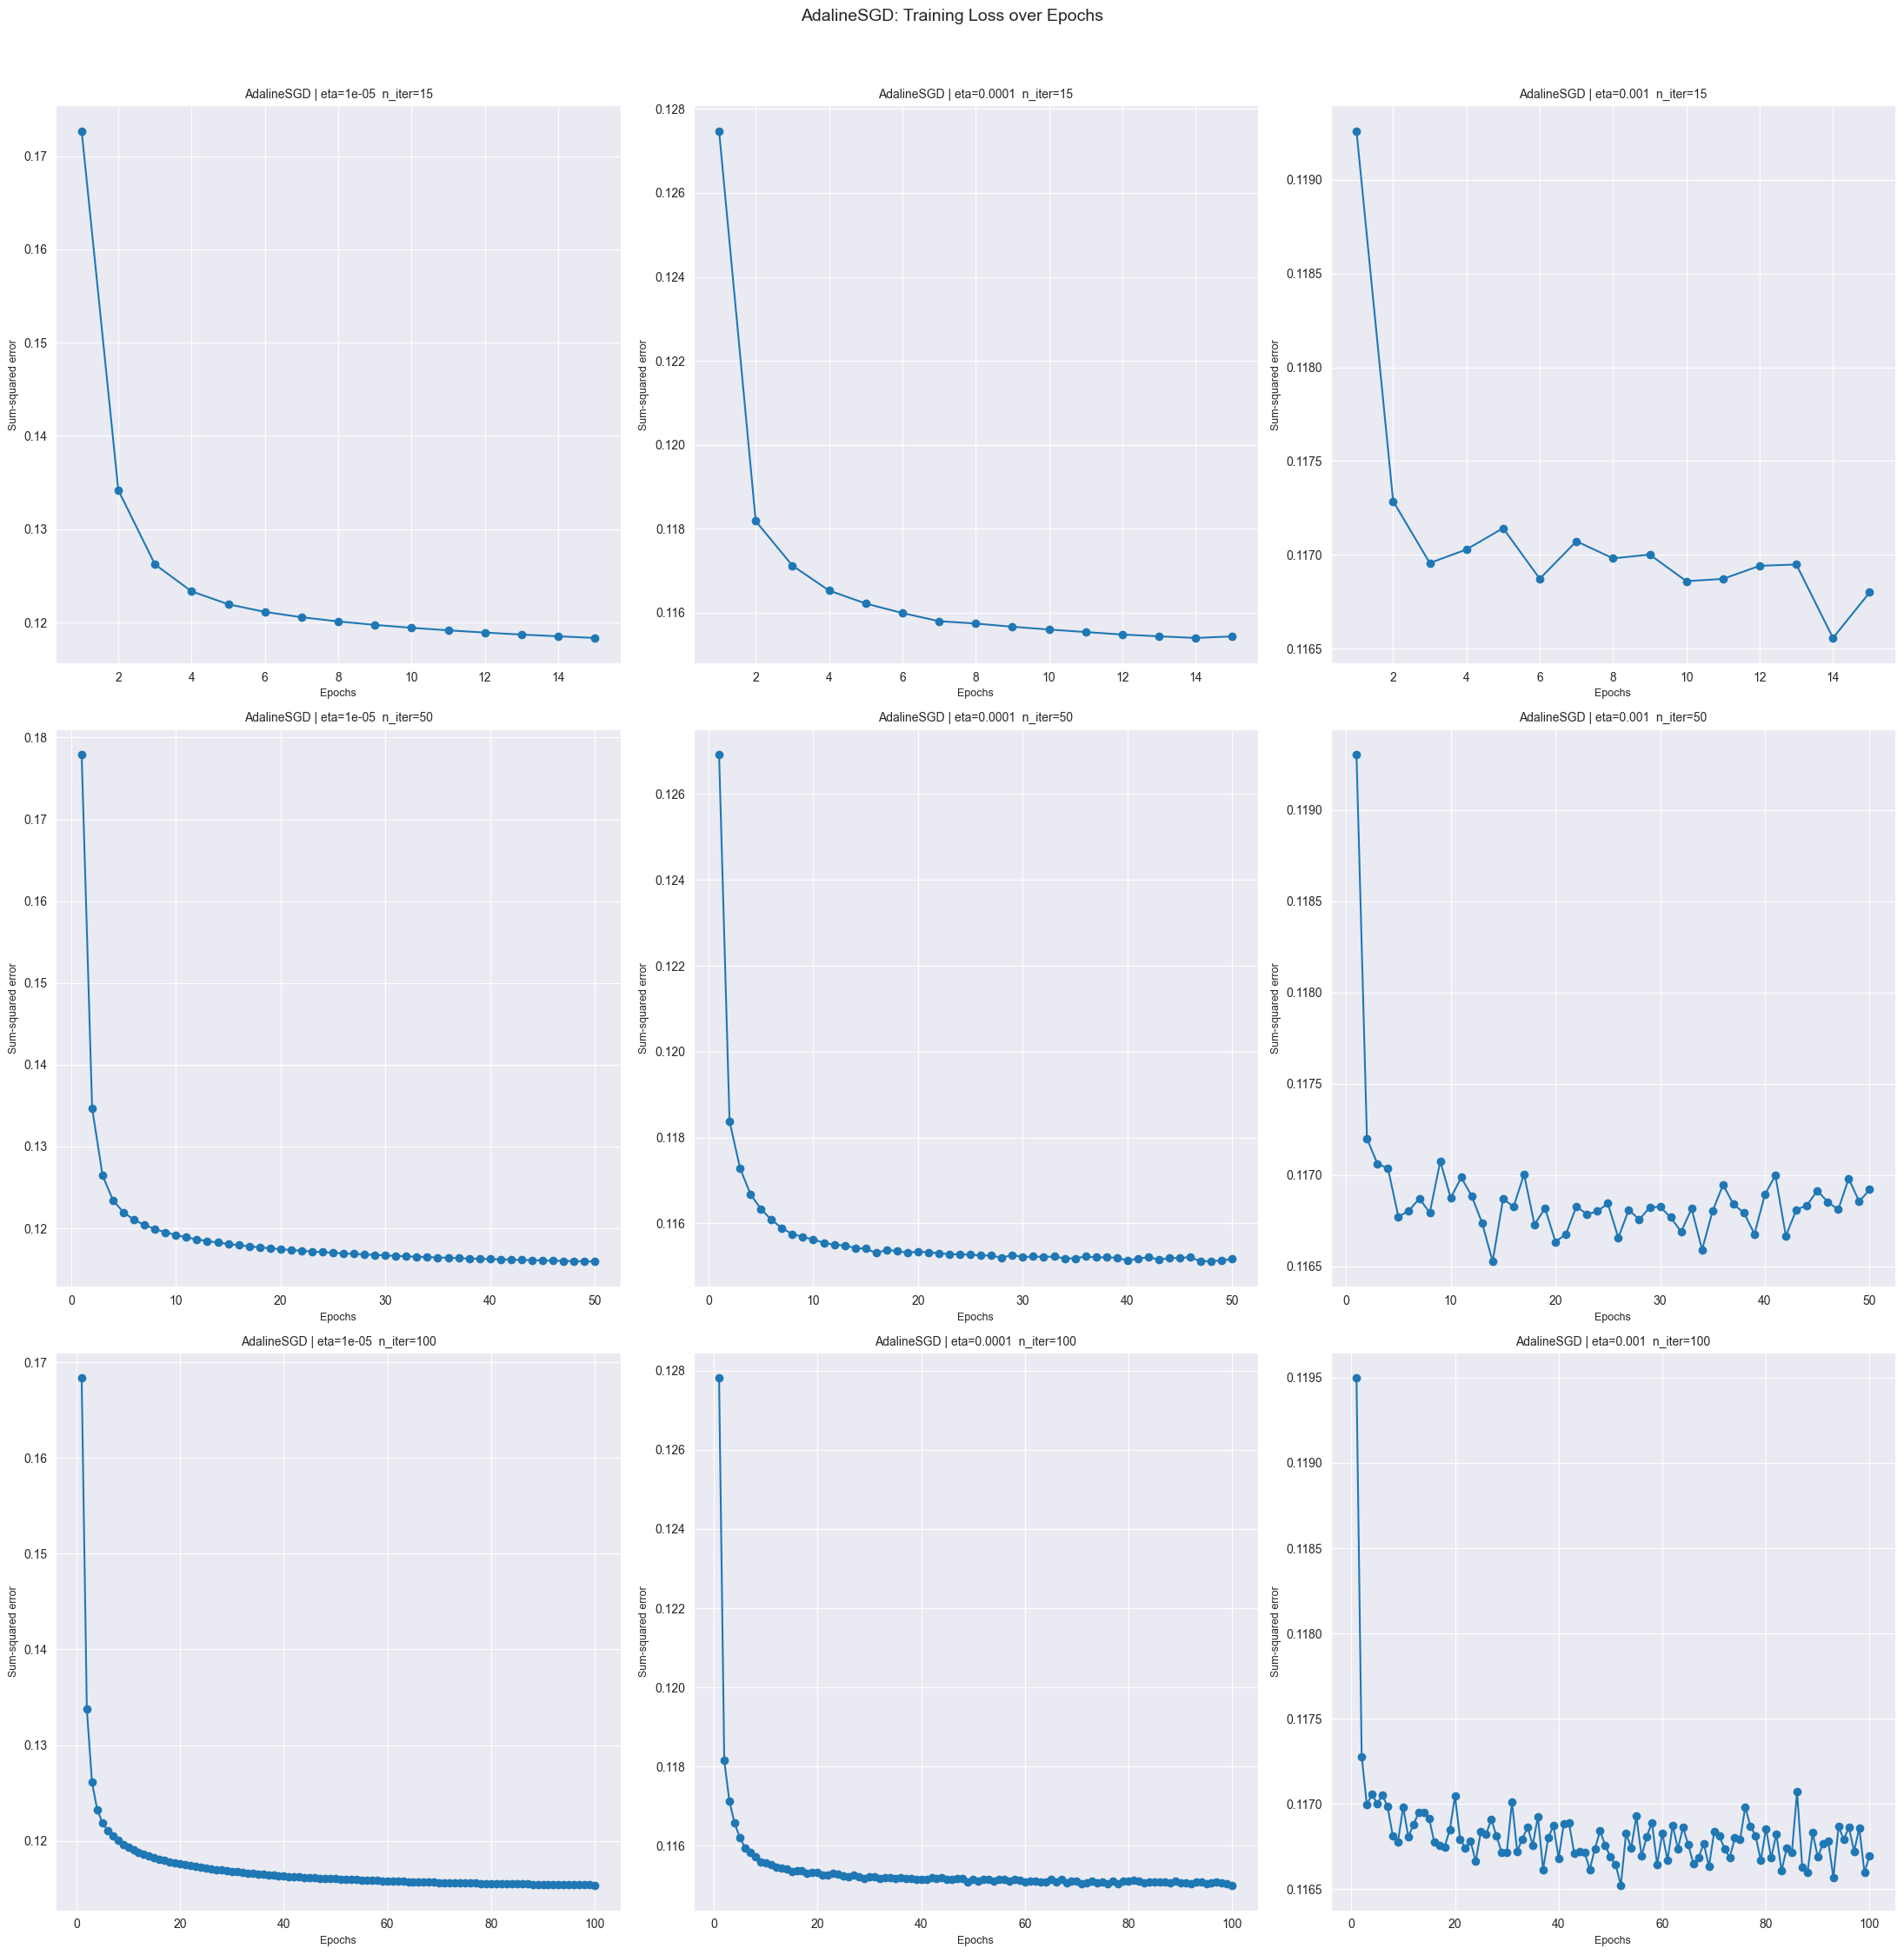

Adaline best config: {'eta': 0.0001, 'n_iter': 100} score: 0.11500716213042239


In [3]:
# handbuilt perceptron and adaline models require data of different shape (numpy arrays)
X_train_perceptron = X_train_processed.values
y_train_perceptron = (y_train == ">50K").astype(int).values

# initialize perceptron and adaline models. iterate through learning rates and iterations to find best hyperparameters
perceptron_eta_list = [0.01, 0.1, 0.5]
perceptron_max_iter_list = [50, 100, 300]

adaline_eta_list = [1e-5, 0.0001, 0.001]
adaline_max_iter_list = [15, 50, 100]

# PERCEPTRON
fig, ax = plt.subplots(nrows=len(perceptron_max_iter_list), ncols=len(perceptron_eta_list), figsize=(22, 22))
best_ppn_score, best_ppn_cfg = np.inf, None
for r, n_iter in enumerate(perceptron_max_iter_list):
    for c, eta in enumerate(perceptron_eta_list):
        ppn = Perceptron(n_iter=n_iter, eta=eta)  # add shuffle/random_state if supported
        ppn.fit(X_train_perceptron, y_train_perceptron)
        hist = getattr(ppn, "errors_", [])
        if len(hist) > 0:
            ax[r, c].plot(range(1, len(hist)+1), hist, marker='o')
            last = hist[-1]
            if last < best_ppn_score:
                best_ppn_score, best_ppn_cfg = last, {"eta": eta, "n_iter": n_iter}
        ax[r, c].set_xlabel("Epochs", fontsize=9)
        ax[r, c].set_ylabel("Number of updates", fontsize=9)
        ax[r, c].set_title(f"Perceptron | eta={eta}  n_iter={n_iter}", fontsize=10)

fig.suptitle("Perceptron: Training Updates over Epochs", fontsize=14, y=1.02)
fig.tight_layout()
plt.show()
print("Perceptron best config:", best_ppn_cfg, "score:", best_ppn_score)

# ADALINE (SGD)
fig, ax = plt.subplots(nrows=len(adaline_max_iter_list), ncols=len(adaline_eta_list), figsize=(22, 22))
best_ada_score, best_ada_cfg = np.inf, None
for r, n_iter in enumerate(adaline_max_iter_list):
    for c, eta in enumerate(adaline_eta_list):
        ada = AdalineSGD(n_iter=n_iter, eta=eta)  # add shuffle/random_state if supported
        ada.fit(X_train_perceptron, y_train_perceptron)
        hist = getattr(ada, "losses_", [])
        if len(hist) > 0:
            ax[r, c].plot(range(1, len(hist)+1), hist, marker='o')
            last = hist[-1]
            if last < best_ada_score:
                best_ada_score, best_ada_cfg = last, {"eta": eta, "n_iter": n_iter}
        ax[r, c].set_xlabel("Epochs", fontsize=9)
        ax[r, c].set_ylabel("Sum-squared error", fontsize=9)
        ax[r, c].set_title(f"AdalineSGD | eta={eta}  n_iter={n_iter}", fontsize=10)

fig.suptitle("AdalineSGD: Training Loss over Epochs", fontsize=14, y=1.02)
fig.tight_layout()
plt.show()
print("Adaline best config:", best_ada_cfg, "score:", best_ada_score)

#### Evaluate adaline and perceptron models:

In [4]:
# create y test sets for both models
y_test_perceptron = (y_test == ">50K").astype(int).values

# predict on test set with best models (perceptron)
best_ppn = Perceptron(eta=0.5, n_iter=50, random_state=42)
best_ppn.fit(X_train_perceptron, y_train_perceptron)
ppn_test_preds = best_ppn.predict(X_test_processed.values)

# (adaline)
best_adaline = AdalineSGD(eta=0.0001, n_iter=100, random_state=42)
best_adaline.fit(X_train_perceptron, y_train_perceptron)
ada_test_preds = best_adaline.predict(X_test_processed.values)

# evaluate results
ppn_accuracy = np.mean(ppn_test_preds == y_test_perceptron)
ada_accuracy = np.mean(ada_test_preds == y_test_perceptron)

# print results
print(f"Perceptron Test Accuracy: {ppn_accuracy:.4f}")
print(f"AdalineSGD Test Accuracy: {ada_accuracy:.4f}")

Perceptron Test Accuracy: 0.7476
AdalineSGD Test Accuracy: 0.8347


#### Predict project validation inputs:

In [5]:
# preprocess data for project validation set
data_handler.load_data_into_class(file_path="data/project_validation_inputs.csv")
validation_data_set = data_handler.pop_dataset_from_class(file_path="data/project_validation_inputs.csv")
processed_validation_set = data_handler.preprocess_set(df=validation_data_set, train_or_test="test")

# predict on validation set with best models
perceptron_validation_preds = best_ppn.predict(processed_validation_set.values)
adaline_validation_preds = best_adaline.predict(processed_validation_set.values)

# print results
np.set_printoptions(threshold=1000000)   # show entire array
print("Perceptron Validation Predictions:", perceptron_validation_preds)
print("Adaline Validation Predictions:", adaline_validation_preds)

Perceptron Validation Predictions: [0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1
 1 1 0 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 0
 0 0 0 1 0 1 1 1 0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0
 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0
 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1
 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1 1 0 1
 0 1 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0
 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1
 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0
 1 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 1 1
 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 

#### Implement sklearn versions of Perceptron and AdalineSGD:

In [6]:
# initialize gridsearchcv for sklearn models
param_grid_ppn = {
    'eta0': [0.01, 0.1, 0.5],
    'max_iter': [50, 100, 300]
}
param_grid_adaline = {
    'eta0': [1e-5, 0.0001, 0.001, 0.01],
    'max_iter': [15, 50, 100, 200]
}

# create sklearn models using gridsearchcv
grid_ppn = GridSearchCV(SklearnPerceptron(random_state=42), param_grid=param_grid_ppn, scoring='accuracy', cv=5)
grid_adaline = GridSearchCV(SGDClassifier(loss='perceptron', learning_rate='constant', random_state=42), param_grid=param_grid_adaline, scoring='accuracy', cv=5)

# fit gridsearchcv models
grid_ppn.fit(X_train_processed, y_train)
grid_adaline.fit(X_train_processed, y_train)

# print best params and scores from gridsearchcv
print("GridSearchCV Perceptron best params:", grid_ppn.best_params_, "best score:", grid_ppn.best_score_)
print("GridSearchCV Adaline (SGD) best params:", grid_adaline.best_params_, "best score:", grid_adaline.best_score_)

# fit sklearn models to our preprocessed data
sklearn_ppn = SklearnPerceptron(eta0=grid_ppn.best_params_['eta0'], max_iter=grid_ppn.best_params_['max_iter'], random_state=42)
sklearn_adaline = SGDClassifier(loss='perceptron', eta0=grid_adaline.best_params_['eta0'], learning_rate='constant', max_iter=grid_adaline.best_params_['max_iter'], random_state=42)

# train sklearn models
sklearn_ppn.fit(X_train_processed, y_train)
sklearn_adaline.fit(X_train_processed, y_train)

# predict with sklearn models
sklearn_ppn_preds = sklearn_ppn.predict(X_test_processed)
sklearn_adaline_preds = sklearn_adaline.predict(X_test_processed)

# evaluate sklearn models
sklearn_ppn_accuracy = accuracy_score(y_test, sklearn_ppn_preds)
sklearn_adaline_accuracy = accuracy_score(y_test, sklearn_adaline_preds)

# print sklearn results
print(f"Sklearn Perceptron Test Accuracy: {sklearn_ppn_accuracy:.4f}")
print(f"Sklearn Adaline (SGD) Test Accuracy: {sklearn_adaline_accuracy:.4f}")

# write csvs
if not os.path.exists("data/outputs/Group_27_Perceptron_PredictedOutputs.csv"):
    np.savetxt("data/outputs/Group_27_Perceptron_PredictedOutputs.csv", sklearn_ppn_preds, delimiter=",", fmt='%s')
if not os.path.exists("data/outputs/Group_27_Adaline_PredictedOutputs.csv"):
    np.savetxt("data/outputs/Group_27_Adaline_PredictedOutputs.csv", sklearn_adaline_preds, delimiter=",", fmt='%s')

GridSearchCV Perceptron best params: {'eta0': 0.01, 'max_iter': 50} best score: 0.8206622779198778
GridSearchCV Adaline (SGD) best params: {'eta0': 1e-05, 'max_iter': 15} best score: 0.8214780168834095
Sklearn Perceptron Test Accuracy: 0.7952
Sklearn Adaline (SGD) Test Accuracy: 0.7960


#### Generate confusion matrix and decision boundaries for both:

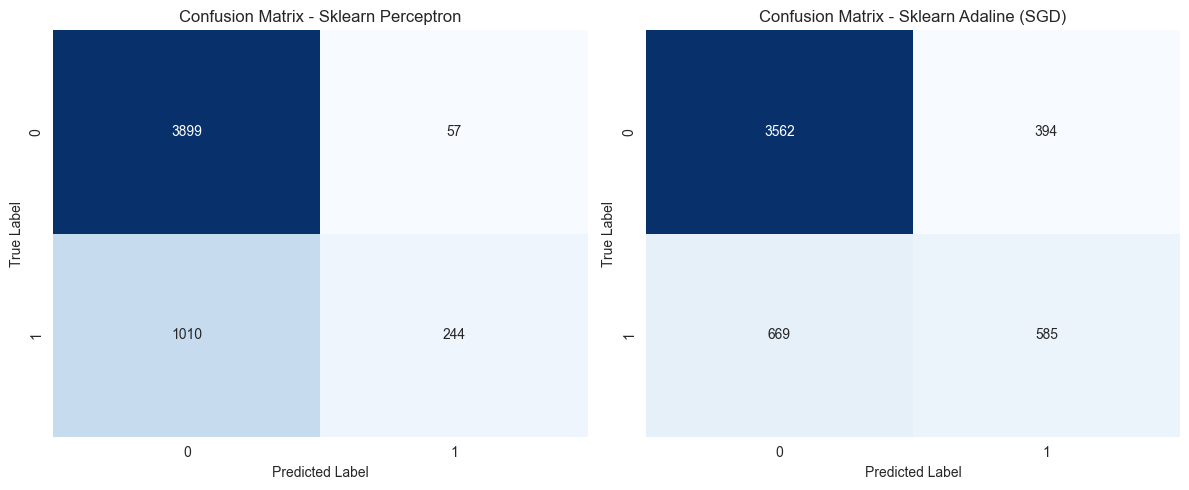

F1 Score - Sklearn Perceptron: 0.3138
F1 Score - Sklearn Adaline (SGD): 0.5240


In [7]:
# create confusion matrix with perceptron and adaline predictions
confusion_matrix_perceptron = confusion_matrix(y_test, sklearn_ppn_preds)
confusion_matrix_adaline = confusion_matrix(y_test, sklearn_adaline_preds)

# plot confusion matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix_perceptron, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Sklearn Perceptron')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix_adaline, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Sklearn Adaline (SGD)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# find f1 scores for both models
f1_score_perceptron = f1_score(y_test, sklearn_ppn_preds, pos_label=">50K")
f1_score_adaline = f1_score(y_test, sklearn_adaline_preds, pos_label=">50K")
print(f"F1 Score - Sklearn Perceptron: {f1_score_perceptron:.4f}")
print(f"F1 Score - Sklearn Adaline (SGD): {f1_score_adaline:.4f}")

#### Implement sklearn versions of Logistic Regression and SVM:

#### Logistic Regression with C=1


--- Confusion Matrix ---
[[3690  266]
 [ 523  731]]

--- Classification Report ---
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      3956
        >50K       0.73      0.58      0.65      1254

    accuracy                           0.85      5210
   macro avg       0.80      0.76      0.78      5210
weighted avg       0.84      0.85      0.84      5210



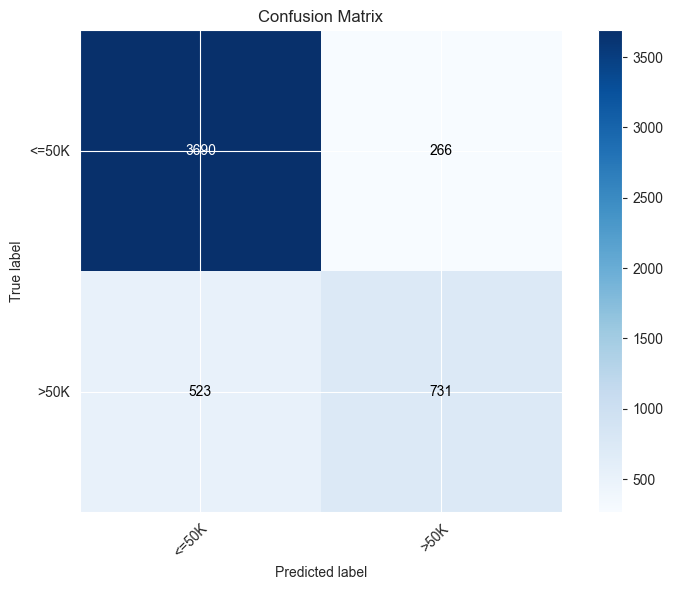

In [8]:

modelC1 = LogisticRegression(solver='lbfgs', random_state=42, max_iter=200, C=1)
modelC1.fit(X_train_processed, y_train.values.ravel())
y_predC1 = modelC1.predict(X_test_processed)

print("\n--- Confusion Matrix ---")
cmC1 = confusion_matrix(y_test, y_predC1)
print(cmC1)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_predC1))

# Plot the predictions and the confusion matrix
pltcm(cmC1, y_test)




#### Logistic Regression with C=.01


--- Confusion Matrix ---
[[3955    1]
 [1214   40]]

--- Classification Report ---
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      3956
        >50K       0.73      0.58      0.65      1254

    accuracy                           0.85      5210
   macro avg       0.80      0.76      0.78      5210
weighted avg       0.84      0.85      0.84      5210



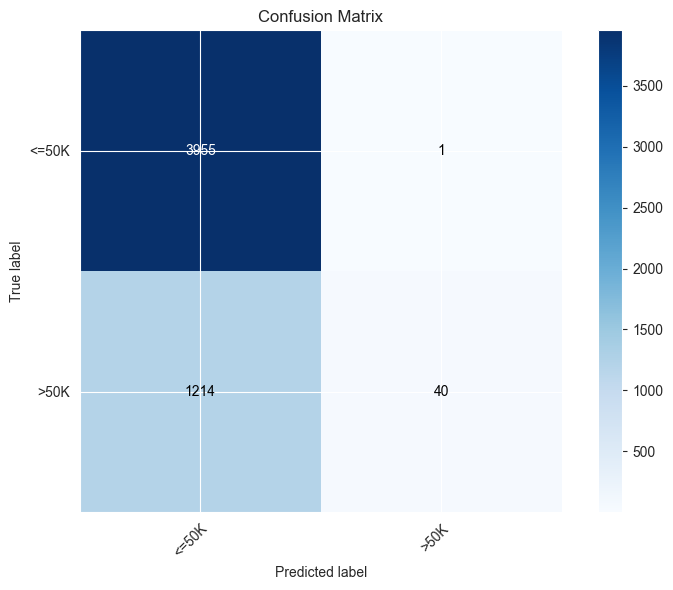

In [9]:

modelC01 = LogisticRegression(solver='lbfgs', random_state=42, max_iter=200, C=.0001)
modelC01.fit(X_train_processed, y_train.values.ravel())
y_predC01 = modelC01.predict(X_test_processed)

print("\n--- Confusion Matrix ---")
cmC01 = confusion_matrix(y_test, y_predC01)
print(cmC01)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_predC1))

# Plot the predictions and the confusion matrix
pltcm(cmC01, y_test)

#### Logistic Regression with C=100


--- Confusion Matrix ---
[[3685  271]
 [ 520  734]]

--- Classification Report ---
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      3956
        >50K       0.73      0.58      0.65      1254

    accuracy                           0.85      5210
   macro avg       0.80      0.76      0.78      5210
weighted avg       0.84      0.85      0.84      5210



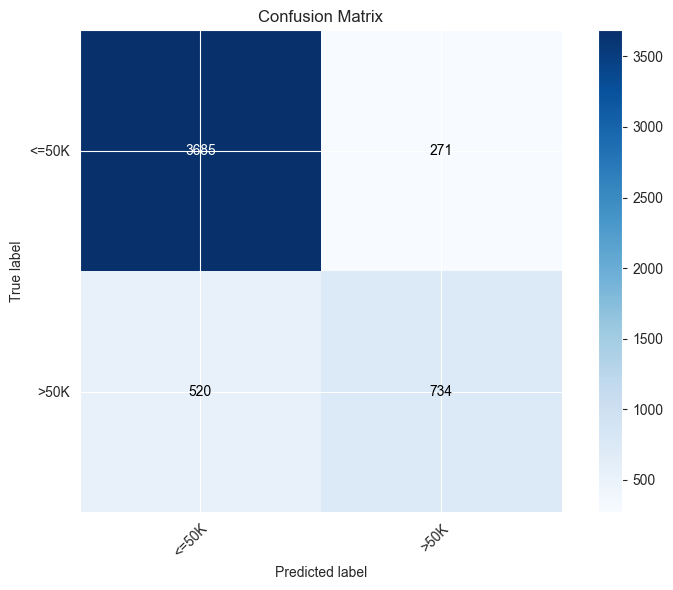

In [10]:

modelC100 = LogisticRegression(solver='lbfgs', random_state=42, max_iter=200, C=100)
modelC100.fit(X_train_processed, y_train.values.ravel())
y_predC100 = modelC100.predict(X_test_processed)

print("\n--- Confusion Matrix ---")
cmC100 = confusion_matrix(y_test, y_predC100)
print(cmC100)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_predC1))

# Plot the predictions and the confusion matrix
pltcm(cmC100, y_test)

#### Logistic Regression with Grid Search

Fitting 5 folds for each of 20 candidates, totalling 100 fits

--- Best Model Found by GridSearchCV ---
Best parameters: {'C': np.float64(11.288378916846883)}
Best cross-validation accuracy: 0.8516

 Final evaluation of the best model on the test set...
Final accuracy on test set: 0.8493

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      3956
        >50K       0.73      0.59      0.65      1254

    accuracy                           0.85      5210
   macro avg       0.81      0.76      0.78      5210
weighted avg       0.84      0.85      0.84      5210


Confusion Matrix:
[[3690  266]
 [ 519  735]]


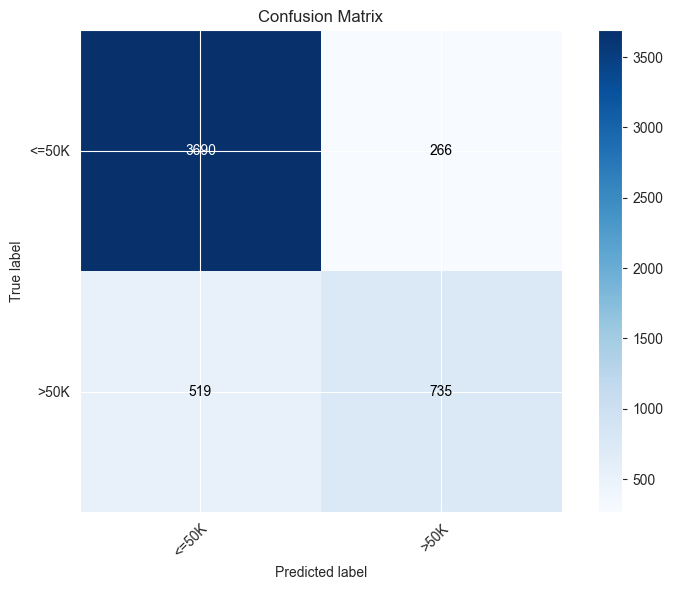

In [11]:
#initialize grid search
param_gridLR = {'C': np.logspace(-4, 4, 20), }

# Initialize GridSearchCV with a 5-fold cross-validation strategy.
grid_searchLR = GridSearchCV(estimator=LogisticRegression(solver='lbfgs', random_state=42, max_iter=200),
    param_grid=param_gridLR,cv=5,scoring='accuracy',n_jobs=-1,verbose=1)



# fit models
grid_searchLR.fit(X_train_processed, y_train.values.ravel())
best_modelLR = grid_searchLR.best_estimator_

# Plot the predictions and the confusion matrix
print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_searchLR.best_params_}")
print(f"Best cross-validation accuracy: {grid_searchLR.best_score_:.4f}")

print("\n Final evaluation of the best model on the test set...")
# Predict using the best model found during the search.
final_y_predLR = best_modelLR.predict(X_test_processed)
final_accuracyLR = accuracy_score(y_test, final_y_predLR)

print(f"Final accuracy on test set: {final_accuracyLR:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_y_predLR))

print("\nConfusion Matrix:")
cmLR = confusion_matrix(y_test, final_y_predLR)
print(cmLR)

# Plot the predictions and the confusion matrix
pltcm(cmLR, y_test)



#### SVM with C=.01


--- Confusion Matrix ---
[[3716  240]
 [ 572  682]]

--- Classification Report ---
              precision    recall  f1-score   support

       <=50K       0.87      0.94      0.90      3956
        >50K       0.74      0.54      0.63      1254

    accuracy                           0.84      5210
   macro avg       0.80      0.74      0.76      5210
weighted avg       0.84      0.84      0.84      5210



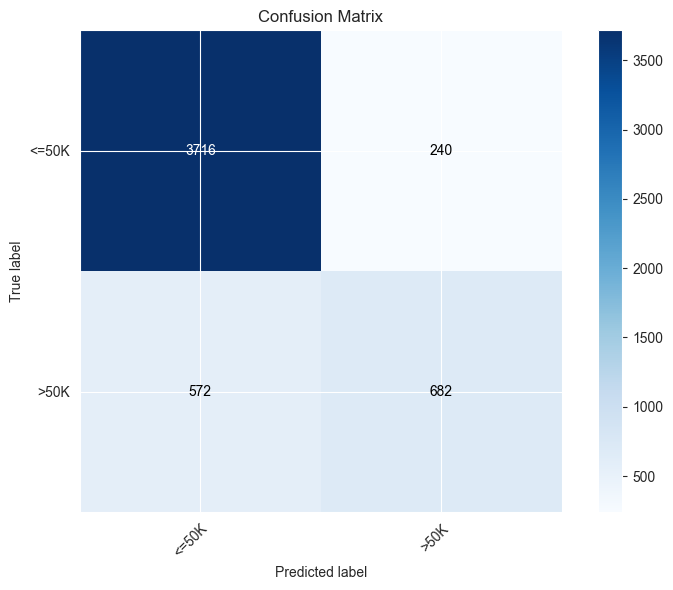

In [12]:
model_SVClinearC01 = SVC(kernel='linear', C=.01)
model_SVClinearC01.fit(X_train_processed, y_train.values.ravel())
y_predSVCC01 = model_SVClinearC01.predict(X_test_processed)
# enerate and display the confusion matrix and classification report
print("\n--- Confusion Matrix ---")
cmSVCC01 = confusion_matrix(y_test, y_predSVCC01)
print(cmSVCC01)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_predSVCC01))

#Plot the predictions and the confusion matrix
pltcm(cmSVCC01, y_test)

#### SVM with C=1


--- Confusion Matrix ---
[[3698  258]
 [ 543  711]]

--- Classification Report ---
              precision    recall  f1-score   support

       <=50K       0.87      0.93      0.90      3956
        >50K       0.73      0.57      0.64      1254

    accuracy                           0.85      5210
   macro avg       0.80      0.75      0.77      5210
weighted avg       0.84      0.85      0.84      5210



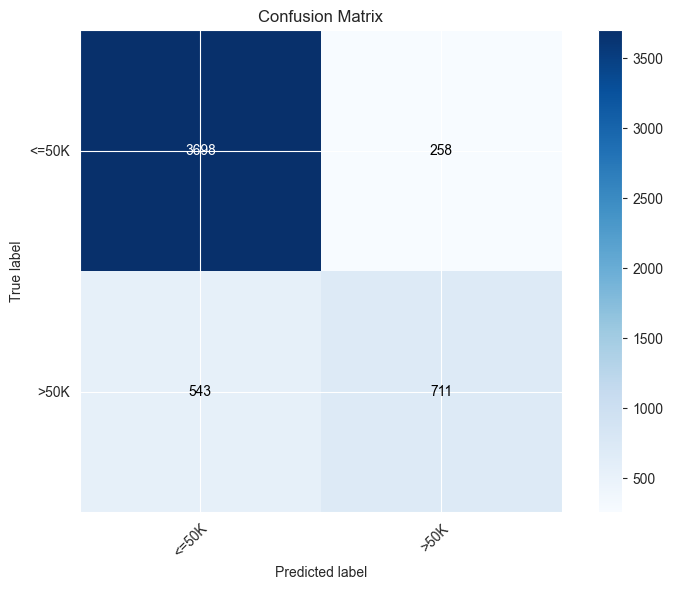

In [13]:
model_SVClinearC1 = SVC(kernel='linear', C=1)
model_SVClinearC1.fit(X_train_processed, y_train.values.ravel())
y_predSVCC1 = model_SVClinearC1.predict(X_test_processed)
# enerate and display the confusion matrix and classification report
print("\n--- Confusion Matrix ---")
cmSVCC1 = confusion_matrix(y_test, y_predSVCC1)
print(cmSVCC1)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_predSVCC1))

#Plot the predictions and the confusion matrix
pltcm(cmSVCC1, y_test)

#### SVM with C=100


--- Confusion Matrix ---
[[3697  259]
 [ 543  711]]

--- Classification Report ---
              precision    recall  f1-score   support

       <=50K       0.87      0.93      0.90      3956
        >50K       0.73      0.57      0.64      1254

    accuracy                           0.85      5210
   macro avg       0.80      0.75      0.77      5210
weighted avg       0.84      0.85      0.84      5210



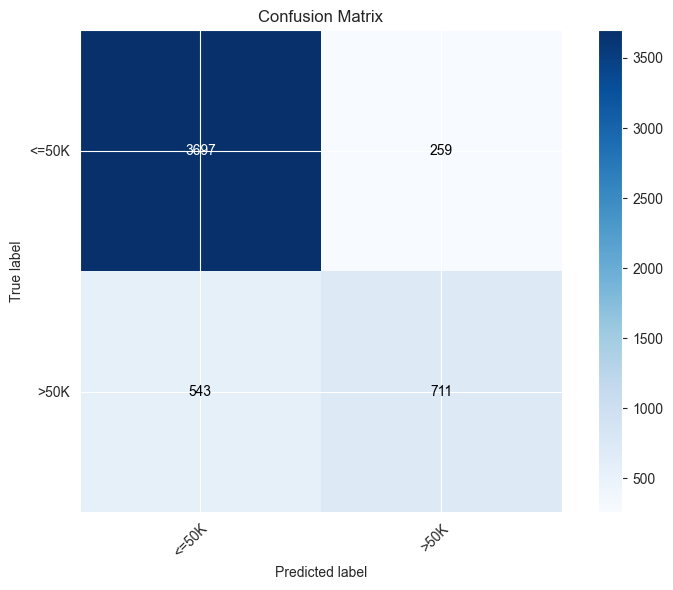

In [14]:
model_SVClinearC100 = SVC(kernel='linear', C=100)
model_SVClinearC100.fit(X_train_processed, y_train.values.ravel())
y_predSVCC100 = model_SVClinearC100.predict(X_test_processed)
# enerate and display the confusion matrix and classification report
print("\n--- Confusion Matrix ---")
cmSVCC100 = confusion_matrix(y_test, y_predSVCC100)
print(cmSVCC100)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_predSVCC100))

#Plot the predictions and the confusion matrix
pltcm(cmSVCC100, y_test)

#### SVM with GridSearchCV

In [15]:
#SVM model with GridSearch and CV
param_gridSVC = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}


# Initialize GridSearchCV with a 5-fold cross-validation strategy.
grid_searchSVC = GridSearchCV(
    estimator=SVC(),
    param_grid=param_gridSVC,
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',       # Metric to optimize for
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                                  # Print progress
)

print("Starting hyperparameter search. This may take a moment...")
grid_searchSVC.fit(X_train_processed, y_train.values.ravel())

Starting hyperparameter search. This may take a moment...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


,estimator,SVC()
,param_grid,"{'C': [0.1, 1, ...], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf', ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,1



--- Best Model Found by GridSearchCV ---
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.8556

 Final evaluation of the best model on the test set...
Final accuracy on test set: 0.8493

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.87      0.94      0.90      3956
        >50K       0.74      0.57      0.65      1254

    accuracy                           0.85      5210
   macro avg       0.81      0.75      0.77      5210
weighted avg       0.84      0.85      0.84      5210


Confusion Matrix:
[[3710  246]
 [ 539  715]]


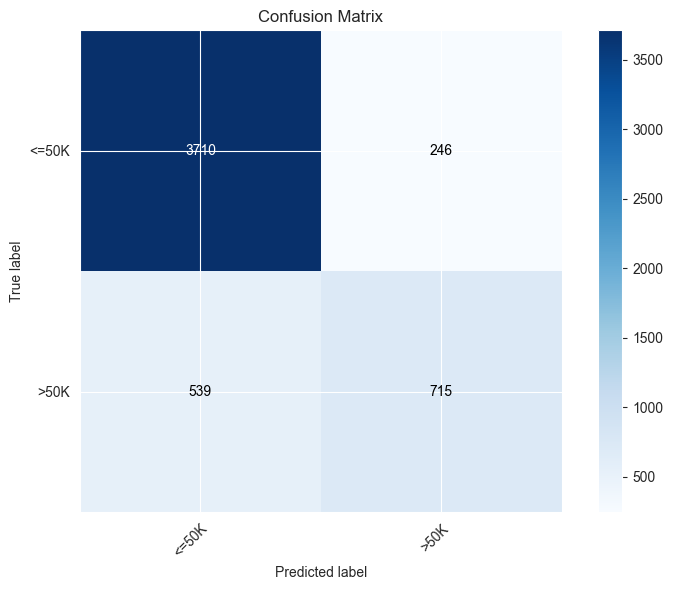

In [16]:
best_modelSVC = grid_searchSVC.best_estimator_

print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_searchSVC.best_params_}")
print(f"Best cross-validation accuracy: {grid_searchSVC.best_score_:.4f}")

print("\n Final evaluation of the best model on the test set...")
# Predict using the best model found during the search.
final_y_pred = best_modelSVC.predict(X_test_processed)
final_accuracy = accuracy_score(y_test, final_y_pred)

print(f"Final accuracy on test set: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_y_pred))

print("\nConfusion Matrix:")
cmSVC = confusion_matrix(y_test, final_y_pred)
print(cmSVC)

# Plot the predictions and the confusion matrix
pltcm(cmSVC, y_test)

#### Accurasies for all Logistic and SVM model:

In [17]:
final_y_predLR = best_modelLR.predict(X_test_processed)
final_accuracyLR = accuracy_score(y_test, final_y_predLR)
final_accuracyLR01 = accuracy_score(y_test, y_predC01)
final_accuracyLR1 = accuracy_score(y_test, y_predC1)
final_accuracyLR100 = accuracy_score(y_test, y_predC100)
final_y_predSVC = best_modelSVC.predict(X_test_processed)
final_accuracySVC = accuracy_score(y_test, final_y_predSVC)
final_accuracySVCC01 = accuracy_score(y_test, y_predSVCC01)
final_accuracySVCC1 = accuracy_score(y_test, y_predSVCC1)
final_accuracySVCC100 = accuracy_score(y_test, y_predSVCC100)
print('Logistic Regression C=.01 accuracy', final_accuracyLR01)
print('Logistic Regression C=1 accuracy', final_accuracyLR1)
print('Logistic Regression C=100 accuracy', final_accuracyLR100)
print('Logistic Regression Grid Search accuracy', final_accuracyLR)
print('SVM accuracy C=.01', final_accuracySVCC01)
print('SVM accuracy C=1', final_accuracySVCC1)
print('SVM accuracy C=100', final_accuracySVCC100)
print('SVM accuracy Grid Search', final_accuracySVC)


Logistic Regression C=.01 accuracy 0.7667946257197696
Logistic Regression C=1 accuracy 0.8485604606525912
Logistic Regression C=100 accuracy 0.8481765834932822
Logistic Regression Grid Search accuracy 0.8493282149712092
SVM accuracy C=.01 0.8441458733205375
SVM accuracy C=1 0.846257197696737
SVM accuracy C=100 0.8460652591170825
SVM accuracy Grid Search 0.8493282149712092


#### Best models inserted into validation set


In [23]:
LR_validation_preds = best_modelLR.predict(processed_validation_set)
SVM_validation_preds = best_modelSVC.predict(processed_validation_set)

print(LR_validation_preds)
print(SVM_validation_preds)

# write csvs
if not os.path.exists("data/outputs/Group_27_LogisticRegression_PredictedOutputs.csv"):
    np.savetxt("data/outputs/Group_27_LogicRegression_PredictedOutputs.csv", LR_validation_preds, delimiter=",", fmt='%s')
if not os.path.exists("data/outputs/Group_27_SVM_PredictedOutputs.csv"):
    np.savetxt("data/outputs/Group_27_SVM_PredictedOutputs.csv", SVM_validation_preds, delimiter=",", fmt='%s')

['<=50K' '<=50K' '>50K' '<=50K' '<=50K' '>50K' '>50K' '<=50K' '<=50K'
 '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '>50K' '>50K'
 '>50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K'
 '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '>50K'
 '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '>50K' '<=50K' '>50K'
 '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K'
 '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K'
 '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K'
 '<=50K' '>50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '>50K'
 '<=50K' '>50K' '>50K' '<=50K' '<=50K' '<=50K' '>50K' '<=50K' '<=50K'
 '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K'
 '<=50K' '>50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '>50K'
 '<=50K' '>50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '<=50K' '>50K'
 '<=50K' '<=50K' '<=50K' '<=50K' '>50K' '<=50K' '<=50K' '<=50K' '<=50

#### Visualize the decision boundaries:

In [19]:
#Initilize decision boundry function
def plot_decision_boundaries_2D(X, y, model, feature_names, title="Decision Boundary"):
    # Ensure numpy arrays
    X = X.values if hasattr(X, "values") else X
    y = y.values if hasattr(y, "values") else y

    # Encode labels if they are not numeric
    if y.dtype == "O" or str(y.dtype).startswith("U"):  # object or string dtype
        le = LabelEncoder()
        y = le.fit_transform(y)

    # Create a meshgrid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    # Predict on the meshgrid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.array(Z)  # just in case
    if Z.dtype == "O":
        le = LabelEncoder()
        Z = le.fit_transform(Z)
    Z = Z.reshape(xx.shape)

    # Plot contour and points
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(("red", "blue")))
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap=ListedColormap(("red", "blue")))
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(title)
    plt.show()

In [20]:
#Finding the best two features to visualize
feature_names = X_train_processed.columns

coefs = np.abs(best_modelLR.coef_[0])

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": best_modelLR.coef_[0],
    "abs_coeff": coefs
})

coef_df = coef_df.sort_values(by="abs_coeff", ascending=False)
print(coef_df.head(10))

#Features with coeffivient values
best_two = coef_df.head(2)["feature"].tolist()
print("Best two features:", best_two)

                                    feature  coefficient  abs_coeff
47          cat__occupation_Priv-house-serv    -2.534601   2.534601
3                         num__capital-gain     2.136807   2.136807
72   cat__native-country_Dominican-Republic    -1.996696   1.996696
28                 cat__education_Preschool    -1.935796   1.935796
70             cat__native-country_Columbia    -1.887191   1.887191
67             cat__native-country_Cambodia     1.625947   1.625947
32    cat__marital-status_Married-AF-spouse     1.615420   1.615420
33   cat__marital-status_Married-civ-spouse     1.556292   1.556292
106          cat__native-country_Yugoslavia     1.535466   1.535466
94                 cat__native-country_Peru    -1.525476   1.525476
Best two features: ['cat__occupation_Priv-house-serv', 'num__capital-gain']


/Users/coymorris/Desktop/CURRENT CLASSES/DASC 41103 — Machine Learning /Project1/project1-foundations_of_classification_algorithms/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


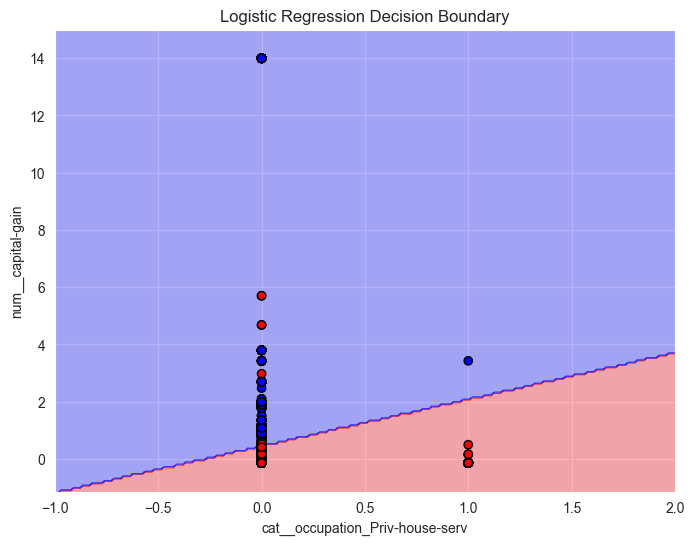

/Users/coymorris/Desktop/CURRENT CLASSES/DASC 41103 — Machine Learning /Project1/project1-foundations_of_classification_algorithms/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


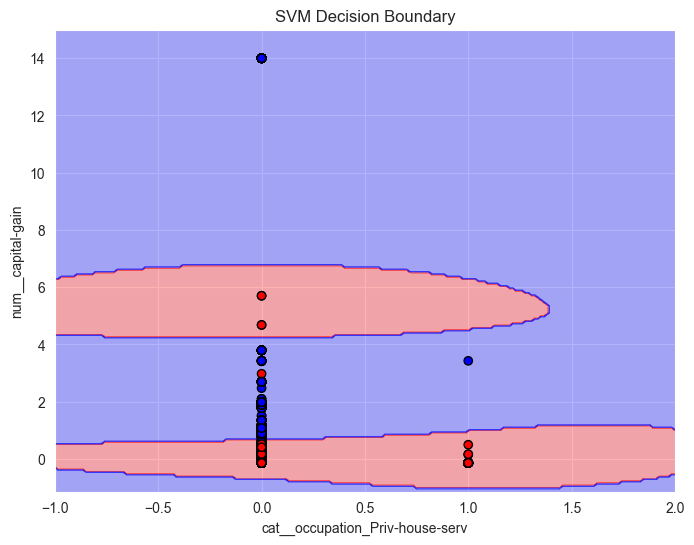

In [21]:
X_train_best2 = X_train_processed[best_two]
y_train_best2 = y_train
#Refit logistic regression on just these two
model_bestLR = LogisticRegression(C=grid_searchLR.best_params_['C'],
                                 solver='lbfgs',
                                 random_state=42,
                                 max_iter=200)
model_bestLR.fit(X_train_best2, y_train_best2)

model_bestSVM = SVC(C=grid_searchSVC.best_params_['C'], gamma='scale',
                    kernel='rbf')
model_bestSVM.fit(X_train_best2, y_train_best2)
# Plot decision boundary
plot_decision_boundaries_2D(X_train_best2, y_train_best2, model_bestLR, best_two, title="Logistic Regression Decision Boundary")
plot_decision_boundaries_2D(X_train_best2, y_train_best2,model_bestSVM, best_two, title= "SVM Decision Boundary")